# Apply the response removal using the poles and zeros

This notebook demonstrates the application of the poles and zeros associated with the AE sensor to the AE event.

# Workflow

1. Read an example of the AE waveform recorded during the stick-slip experiment. We have cleaned up the AE waveform by demean, detrend, tapering, and band-pass filtering between 60kHz and 600kHz. See `convert_and_save_AEevent_fb03-087.ipynb` for the details.
2. Load the poles, zeros, and scaling factors dumped from `01_AEsensor_calibration_arx.ipynb`.
3. Remove the response from the AE waveform.
4. plot the amplitude and frequency responses, and the comparison of the waveforms before and after the response removal .

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import pickle
import warnings

import obspy
from obspy import read, Stream, Trace
from obspy.signal.util import _npts2nfft
from obspy.core.utcdatetime import UTCDateTime  

from remove_resp_digitalfilt import *

plt.rcParams["font.family"] = 'Arial'
plt.rcParams["font.size"] = 12
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["xtick.major.size"] = 4.75
plt.rcParams["xtick.major.width"] = 0.75
plt.rcParams["xtick.minor.size"] = 3
plt.rcParams["xtick.minor.width"] = 0.4
plt.rcParams["xtick.minor.visible"] = True

plt.rcParams["ytick.direction"] = "in"
plt.rcParams["ytick.major.size"] = 4.75
plt.rcParams["ytick.major.width"] = 0.75
plt.rcParams["ytick.minor.size"] = 3
plt.rcParams["ytick.minor.width"] = 0.4
plt.rcParams["ytick.minor.visible"] = True

plt.rcParams["savefig.transparent"] = True
plt.rcParams['axes.linewidth'] = 0.75
    
os.environ['TZ'] = 'GMT' # change time zone to avoid confusion in unix_tvec conversion

UTCDateTime.DEFAULT_PRECISION = 8

# Read an example of the laboratory AE waveform

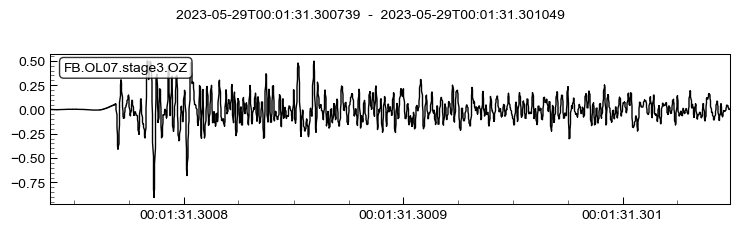

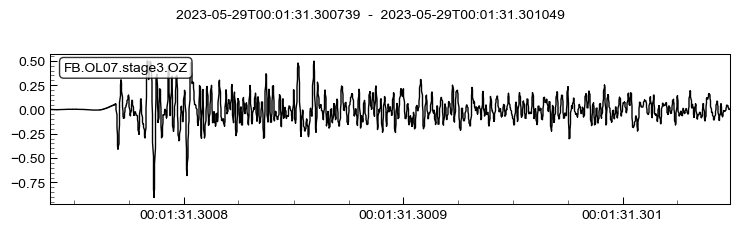

In [2]:
tr = read("../data/AE_waveform_fb03-087_OL07.sac")[0]
tr.plot()

# Load the poles and zeros

In [3]:
# Read response of AE sensor
AEcalib_casename = "fronttop"
D = sio.loadmat(f"../data/AE_resp_dataandcoef_{AEcalib_casename}");
D.keys()
# remove response using the function
poles_AE = np.squeeze(D["p"])
zeros_AE = np.squeeze(D["z"])
scale_fac_AE = np.squeeze(D["k"])

In [4]:
# load the raw input (LDV) and output (AE) used for the calibration to compute the bode plot.
fs = tr.stats.sampling_rate
tr_u = Trace()
tr_u.stats.sampling_rate = fs
tr_u.stats.network = "N"
tr_u.stats.station = "IN"
tr_u.stats.channel = "Z"
tr_u.data = np.squeeze(D["u_input_raw"])

tr_y = tr_u.copy()
tr_y.stats.station = "OUT"
tr_y.stats.channel = "Z"
tr_y.data = np.squeeze(D["y_output_raw"])



In [5]:
b, a = signal.zpk2tf(zeros_AE, poles_AE, scale_fac_AE)
b, a

(array([   894.99095553,  -5099.47309433,  13709.89320355, -23946.75362484,
         31802.37986934, -35177.05533389,  33608.53718702, -27555.63124012,
         18623.49773453,  -9562.94187416,   3221.90288289,   -519.22026877,
             0.        ,      0.        ,      0.        ,      0.        ,
             0.        ,      0.        ,      0.        ,      0.        ,
             0.        ,      0.        ,      0.        ,      0.        ,
             0.        ]),
 array([  1.        ,  -6.41742904,  18.01902892, -28.57729485,
         27.43164937, -15.7089683 ,   4.49684454,   1.44634807,
         -5.09462226,   6.72661096,  -4.82499391,   1.90805373,
         -0.81803233,   0.70628718,  -0.3767331 ,   0.24291072,
         -0.24402689,  -0.10065524,   0.38577828,  -0.29911229,
          0.29080946,  -0.47429531,   0.45856885,  -0.21847657,
          0.04179105]))

# Apply the response removal

We modified the `obspy.core.trace,remove_response` (https://docs.obspy.org/packages/autogen/obspy.core.trace.Trace.remove_response.html) to adopt the digital filter of ARX model, which is implemented in the `remove_resp_digitalfilt.py`.

In [6]:
print(remove_resp_digitalfilt.__doc__)


    Remove response using the sensor response estimated as digital filter
    y(z) = G(z)u(z)

    Original code is the module of remove_response in obspy.core.trace:
    
    Reference:
    https://docs.obspy.org/_modules/obspy/core/trace.html#Trace.remove_response

    Reference:
    [1] Krischer, L., Megies, T., Barsch, R., Beyreuther, M., Lecocq, T., Caudron, C., and Wassermann, J.
    Obspy: a bridge for seismology into the scientific python ecosystem.
    Computational Science & Discovery, 8(1):014003, 2015, doi:10.1088/1749-4699/8/1/014003.

    2022.07.29 Kurama Okubo: modify the original code to adapt the digital filter using signal.freqz
    


In [7]:
pre_filt = (5e3, 1e4, 1e6, 2e6) # prefilter for the remove_resp
water_level = 60 # waterlevel [dB] for the remove_resp

tr_respremoved, freqs, freq_domain_taper, data_after_freqtapered, freq_response_forward, freq_response = remove_resp_digitalfilt(tr, poles_AE, zeros_AE, scale_fac_AE, pre_filt=pre_filt, water_level=60, zero_mean=True,
    taper=True, taper_fraction=0.05, detrend=True, debug=True)

In [8]:
# Save the test data
np.savez("../data/testdata_remove_resp_digitalfilt.npz", data=tr_respremoved.data, freqs=freqs);

# Bode plot

In [9]:
# compute G by just dividing y from u
nfft = _npts2nfft(tr.stats.npts)
U = np.fft.rfft(tr_u.data, n=nfft)
Y = np.fft.rfft(tr_y.data, n=nfft)
g_freqs = np.fft.rfftfreq(nfft, d=1/fs)
g_est = Y/U

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


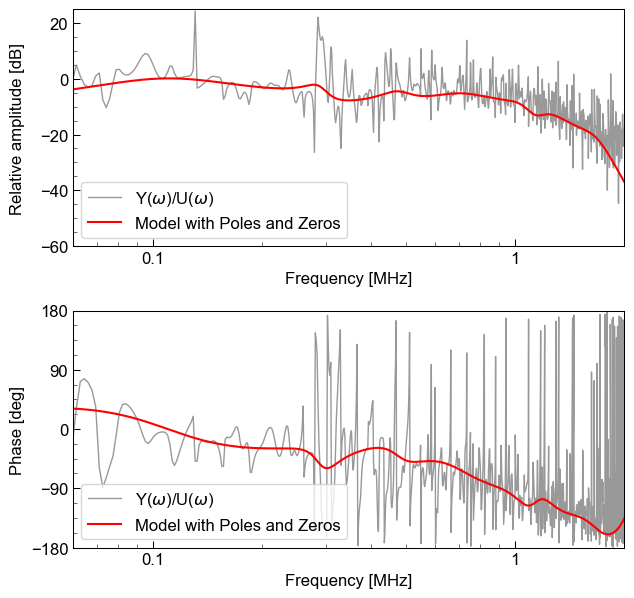

In [10]:
fig, axs = plt.subplots(2, 1, figsize=(6.5, 6.15))
xlimit = [6e4/1e6, 2e6/1e6]

A0_dB_freqind = np.where(g_freqs > 0.1e6)[0][0]
A0_dB = abs(freq_response_forward[A0_dB_freqind])
lc_raw = [0.6, 0.6, 0.6]
axs[0].semilogx(g_freqs/1e6, 20 * np.log10(abs(g_est)/A0_dB), "-", c=lc_raw, label=r"Y($\omega$)/U($\omega$)", lw=1)
axs[0].semilogx(freqs/1e6, 20 * np.log10(abs(freq_response_forward)/A0_dB), "r-", label="Model with Poles and Zeros", lw=1.5)

axs[0].set_xlabel("Frequency [MHz]")
axs[0].set_ylabel("Relative amplitude [dB]")
axs[0].set_xlim(xlimit)
axs[0].set_ylim([-60, 25])
axs[0].set_xticks([0.1, 1])
axs[0].set_xticklabels([0.1, 1])


# axs[0].set_ylim([40, 100])
axs[0].legend(loc=3)


# angles_gest = np.unwrap(np.angle(g_est)) # unwrap the angle to make it continuous; not applied for this figure
# angles_paz = np.unwrap(np.angle(freq_response_forward))
angles_gest = np.angle(g_est)
angles_paz = np.angle(freq_response_forward)

axs[1].semilogx(g_freqs/1e6, np.rad2deg(angles_gest), c=lc_raw, label=r"Y($\omega$)/U($\omega$)", lw=1)
axs[1].semilogx(freqs/1e6, np.rad2deg(angles_paz), 'r', label="Model with Poles and Zeros", lw=1.5)

axs[1].set_xlabel("Frequency [MHz]")
axs[1].set_ylabel('Phase [deg]')
axs[1].set_ylim([-180, 180])
axs[1].set_yticks([-180, -90, 0, 90, 180])
axs[1].set_xlim(xlimit)
axs[1].set_xticks([0.1, 1])
axs[1].set_xticklabels([0.1, 1])
axs[1].legend(loc=3)

# for i in range(2):
    # axs[i].grid(True, c=np.array([230, 230, 230])/255, lw=0.25, which="both",)
    # axs[i].set_axisbelow('True')

fig.align_ylabels(axs)
plt.tight_layout()
plt.savefig(f"../figure/AEsensor_bode_{AEcalib_casename}.png", dpi=300)
plt.savefig(f"../figure/AEsensor_bode_{AEcalib_casename}.eps")


**NOTE:** The amplitude response associated with the model with poles and zeros is smaller than the raw estimation by Y/U in high-frequency band due to the band-pass filter applied before the the least square method of ARX model to stabilize the solutions. 

In [11]:
len(poles_AE), len(zeros_AE[zeros_AE != 0 ])

(24, 11)

In [12]:
zeros_AE

array([ 0.        +0.j        ,  0.        +0.j        ,
        0.        +0.j        ,  0.        +0.j        ,
        0.        +0.j        ,  0.        +0.j        ,
        0.        +0.j        ,  0.        +0.j        ,
        0.        +0.j        ,  0.        +0.j        ,
        0.        +0.j        ,  0.        +0.j        ,
        0.        +0.j        , -0.42316721+0.85963822j,
       -0.42316721-0.85963822j,  0.20261246+0.89385895j,
        0.20261246-0.89385895j,  0.71736636+0.61962525j,
        0.71736636-0.61962525j,  0.90310435+0.28404011j,
        0.90310435-0.28404011j,  0.97570733+0.j        ,
        0.96112682+0.18323452j,  0.96112682-0.18323452j])

# Compare before and after the response removal

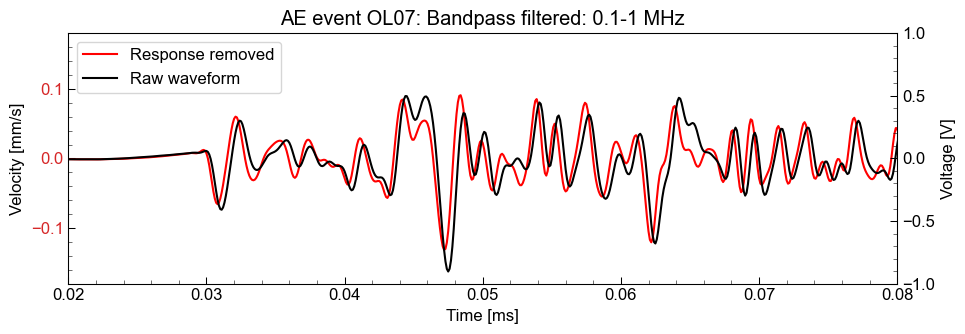

In [13]:
fig, ax1 = plt.subplots(1, 1, figsize=(10, 3.5))

freqmin = 1e5
freqmax = 1e6

tvec = (tr.times())*1e3 #

p1 = ax1.plot(tvec, tr_respremoved.data*1e3, "r-", label="Response removed")
ax1.set_xlim([0.02, 0.08])
ax1.set_ylim([-0.18, 0.18])
ax1.set_xlabel("Time [ms]")
ax1.set_ylabel("Velocity [mm/s]")
ax1.tick_params(axis='y', labelcolor="tab:red")

ax2 = ax1.twinx()
p2 = ax2.plot(tvec, tr.data, "k-", label="Raw waveform")
ax2.set_ylabel("Voltage [V]")
ax2.set_ylim([-1, 1])

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc=2)

ax2.set_title(f"AE event {tr_respremoved.stats.station}: Bandpass filtered: {freqmin/1e6:.1f}-{freqmax/1e6:.1g} MHz")
plt.tight_layout()
plt.savefig(f"../figure/comparison_AEresponse_removal_{tr_respremoved.stats.station}_{AEcalib_casename}.png", dpi=300) 
# plt.savefig(f"../figure/comparison_AEresponse_removal_{tr_respremoved.stats.station}.eps", dpi=300) 

**NOTE:** We can find the correction of the phase delay from the raw waveform in the figure above. The `remove_resp_digitalfilt` can stably remove the instrumental response associated with the AE sensors to archive the quantitative analysis of the waveforms. 

In [14]:
scale_fac_AE

array(894.99095553)